# Supernova distances and redshifts 
Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

Let's recall the definition of magnitude and the distance modulus (ah! the astronomers...)

$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$

Here is the Hubble diagram for Type Ia supernovae (which are standard candels). The lines show the predictions for cosmologies with varying amounts of Ωm and ΩΛ. The observed points all lie above the line for a universe with zero Λ. The lower panel, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and shows why a model with ΩΛ > 0 is favored. 

####  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

In [1]:
#stuff I need: 

from astroML.datasets import generate_mu_z
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import LinearRegression
from astroML.linear_model import NadarayaWatson
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

from scipy.optimize import fmin_cobyla
from scipy.optimize import curve_fit
from scipy.stats import norm

import emcee
import random
import dynesty
from dynesty.utils import resample_equal
import scipy
import numpy as np
import pylab as plt
from matplotlib import pyplot as plt
import corner
import time
from tabulate import tabulate
%matplotlib inline
%config InlineBackend.figure_format='retina'

/opt/anaconda3/lib/python3.9/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


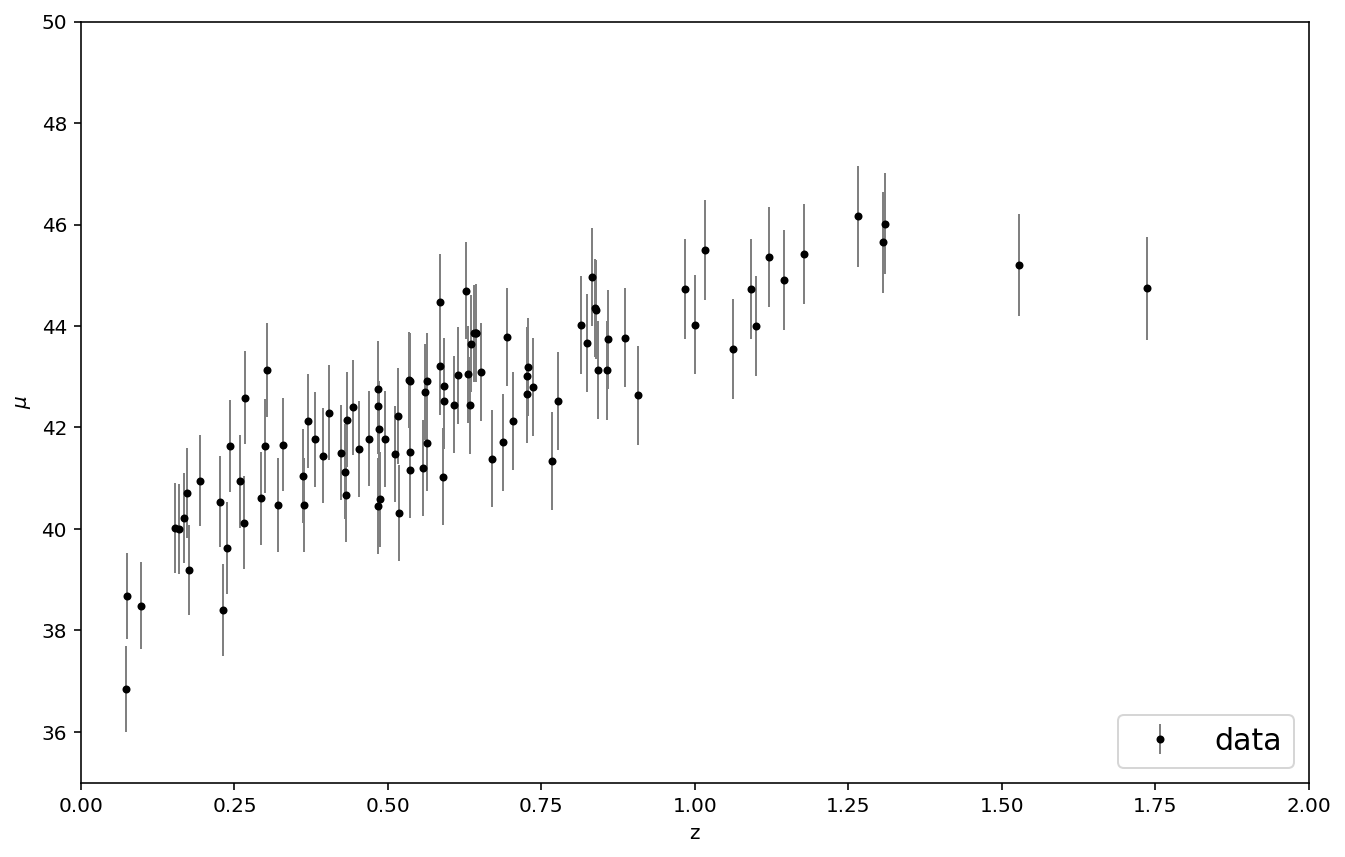

In [2]:
# fetching data
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)
plt.figure(figsize=(11, 7))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right', fontsize=15)
plt.xlim(0,2)
plt.ylim(35,50);

In [3]:
dataset_ = np.array((z_sample, mu_sample)).T

In [4]:
dataset_corr_ = dataset_[dataset_[:, 0].argsort()] # sorting just for the sake of good plotting

z = np.linspace(0.01, 2, 1000) # for when I'll do the predicting 

In [5]:
# cv split

X_train, X_cv, ydy_train, ydy_cv = train_test_split(dataset_corr_[:, 0], np.array([dataset_corr_[:, 1],dmu]).T, test_size=0.3, random_state=1)  # ydy to have also errors to work with
Y_train, dy_train = ydy_train.T
Y_cv,dy_cv = ydy_cv.T

---

# Exploring the techniques

### Linear Regression

- Sklearn

In [6]:
model_sklearn = LinearRegression()
model_sklearn.fit(dataset_corr_[:, 0][:, None], dataset_corr_[:, 1][:, None], sample_weight=1.0)
mu_pred_sklearn = model_sklearn.predict(dataset_corr_[:, 0][:, None])

In [7]:
print("alpha:", model_sklearn.coef_, "; intercept:", model_sklearn.intercept_)

alpha: [[4.64711848]] ; intercept: [39.56505555]


- AstroML

Differently from Sklearn, it takes into account the possibility for heteroscedastic error (dmu). 

In [8]:
model_ML = LinearRegression()
model_ML.fit(dataset_corr_[:, 0][:, None], dataset_corr_[:, 1][:, None], dmu)
mu_pred_ML = model_ML.predict(dataset_corr_[:, 0][:, None])

In [9]:
print("alpha:", model_ML.coef_, "; intercept:", model_ML.intercept_)

alpha: [[4.6421595]] ; intercept: [39.57112419]


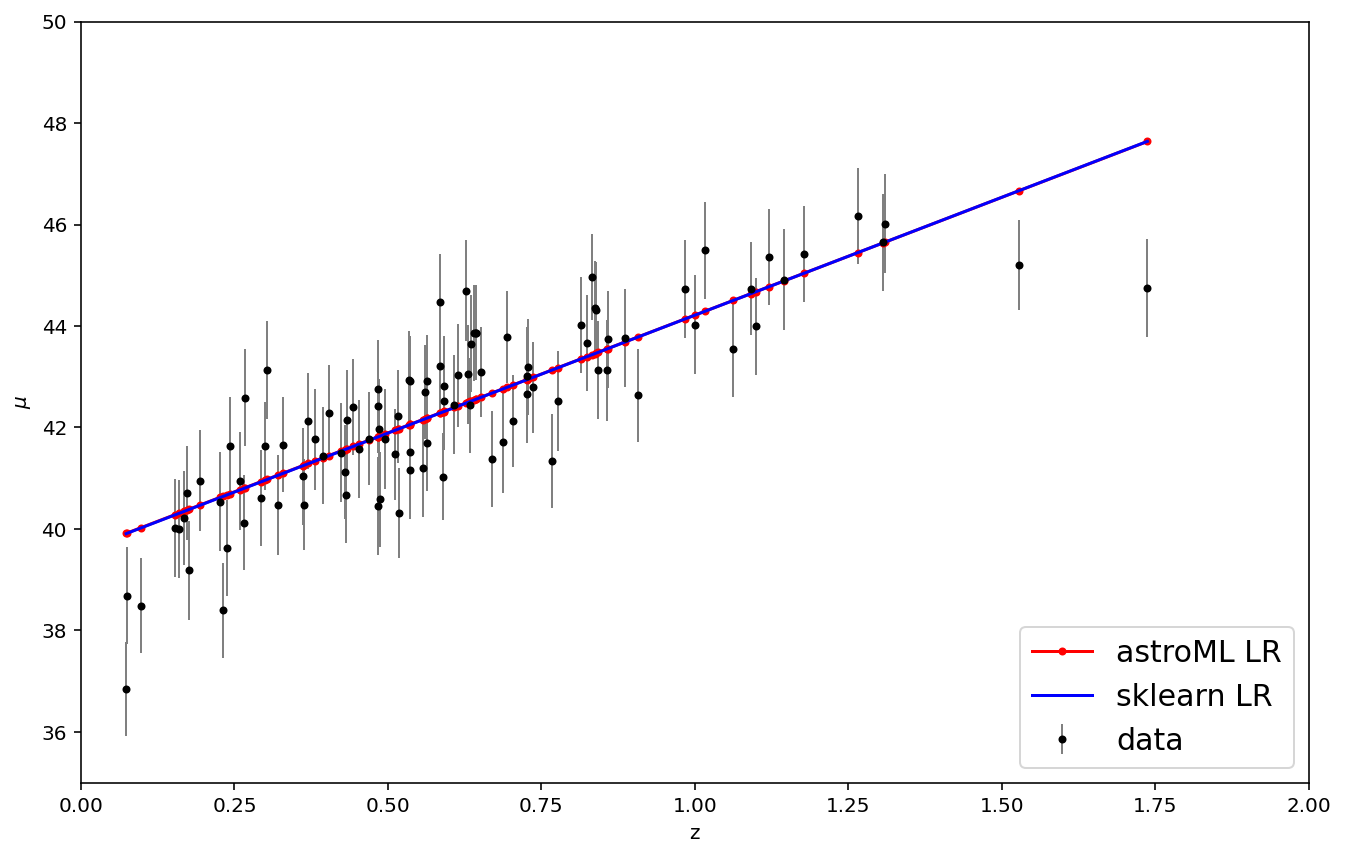

In [10]:
plt.figure(figsize=(11, 7))
plt.errorbar(dataset_corr_[:, 0], dataset_corr_[:, 1], dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.plot(dataset_corr_[:, 0], mu_pred_ML, c='red', label='astroML LR', marker='.')
plt.plot(dataset_corr_[:, 0], mu_pred_sklearn, c='blue', label='sklearn LR')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right', fontsize=15)
plt.xlim(0,2)
plt.ylim(35,50);

They return the same fit!

### Polinomial Regression

In [11]:
model_poly = {}
model_coeff = {}
mu_pred_poly = {}
n_constraints = {}
 
for i in range(1, 7): 

    degree = i
    model_poly[f'{i}'] = PolynomialRegression(degree) 
    model_poly[f'{i}'].fit(dataset_corr_[:, 0][:, None], dataset_corr_[:, 1], dmu)
    model_coeff[f'{i}'] = model_poly[f'{i}'].coef_

    mu_pred_poly[f'{i}'] = model_poly[f'{i}'].predict(z[:, None])
    n_constraints[f'{i}'] = degree + 1
    

In [12]:
# nice function to plot a dictionary in an ordered way:
def print_modelcoeff(dct):
    
    print("n coeff / values")
    print(" ")
    
    for n_coeff, values in dct.items():  
        
        print("{}: ({})".format(n_coeff, values))

In [13]:
print_modelcoeff(model_coeff)

n coeff / values
 
1: ([39.55329971  4.65658525])
2: ([38.42232154  8.5365867  -2.59817659])
3: ([38.46307501  8.29870416 -2.24394388 -0.14393826])
4: ([ 37.05705797  20.55669167 -32.31075065  26.85521433  -7.86510687])
5: ([ 36.12905078  31.55950786 -71.96764357  86.33101968 -46.6565537
   9.05664251])
6: ([  35.42642508   42.3140279  -124.7080907   201.05369774 -168.72853587
   71.11248642  -12.02173303])


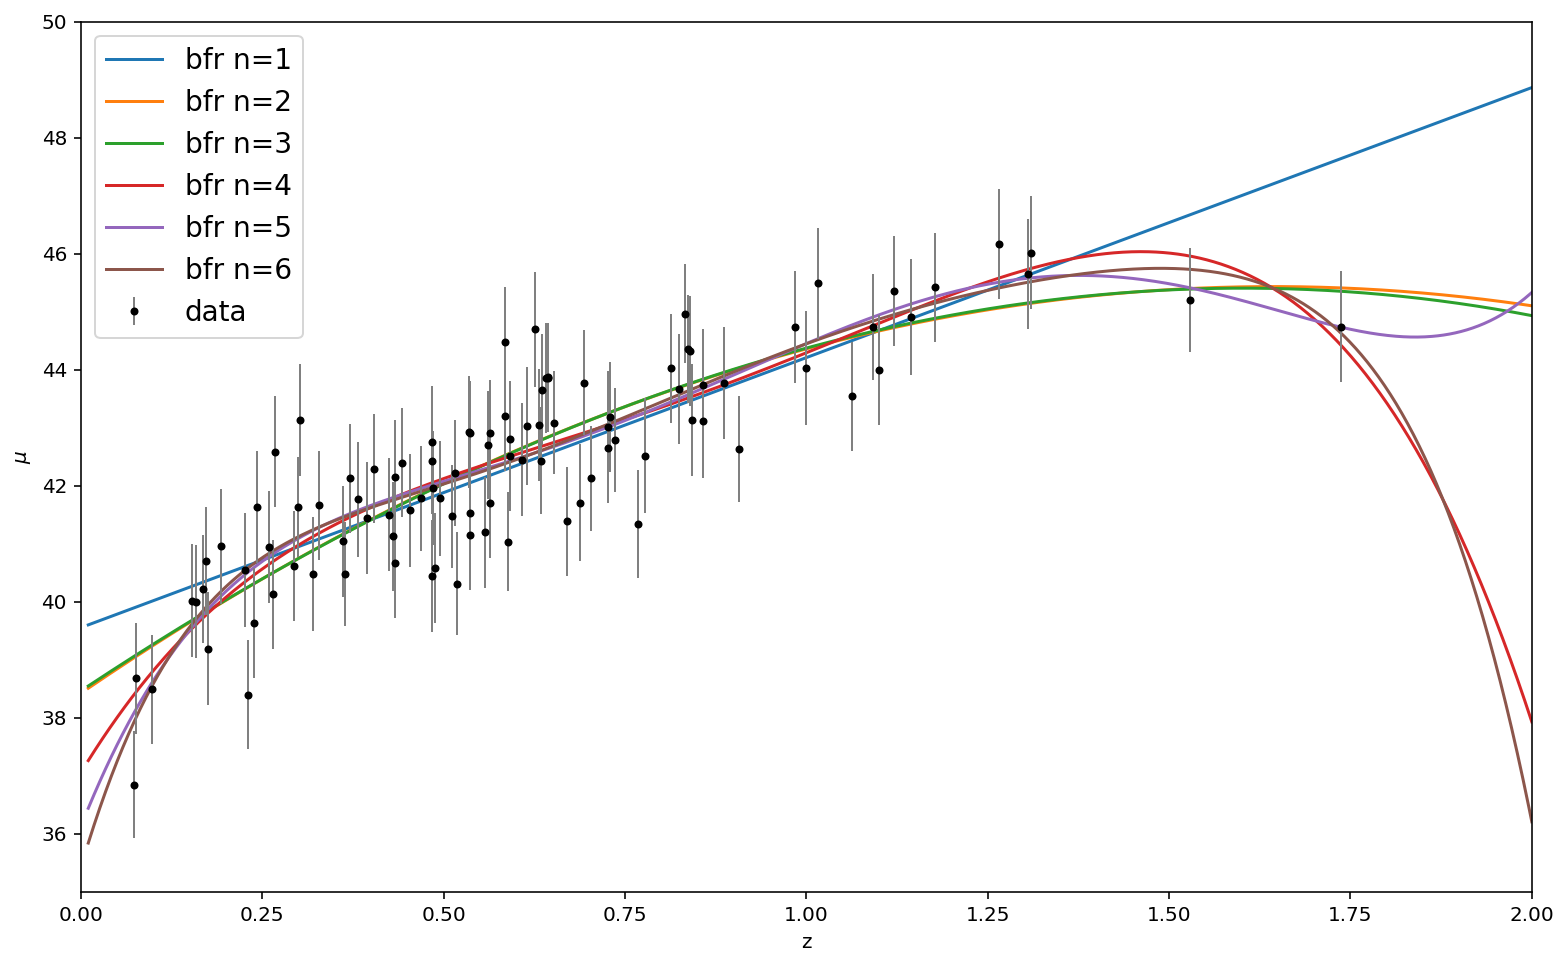

In [14]:
plt.figure(figsize=(13, 8))

for i in np.arange(1, 7):  # best plotting option taken from solutions
    
    plt.plot(z, mu_pred_poly[f'{i}'], label='bfr n='+str(i))
    
plt.errorbar(dataset_corr_[:, 0], dataset_corr_[:, 1], dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left', fontsize=14)
plt.xlim(0,2)
plt.ylim(35,50);

My guess from this fit is that a 2/3/4th degree polynomial could be a good choice to describe our data; higher degrees are clearly overfitting our data, while the lower ones (meaning just 1 in this case) are underfitting them.

### Basis function regression

In [15]:
model_bfr = {}
mu_pred_bfr = {}
 
for i in np.arange(1,20)[1::4]: 

    # mean positions of the i Gaussians in the model
    X_gridtest = np.linspace(0, 2, i)[:, None]

    # widths of these Gaussians
    sigma_test = float(X_gridtest[1]-X_gridtest[0])
    
    model_bfr = BasisFunctionRegression(basis_func='gaussian', mu=X_gridtest, sigma=sigma_test)
    model_bfr.fit(dataset_corr_[:, 0][:, None], dataset_corr_[:, 1], dmu)

    mu_pred_bfr[f'{i}'] = model_bfr.predict(z[:, None])

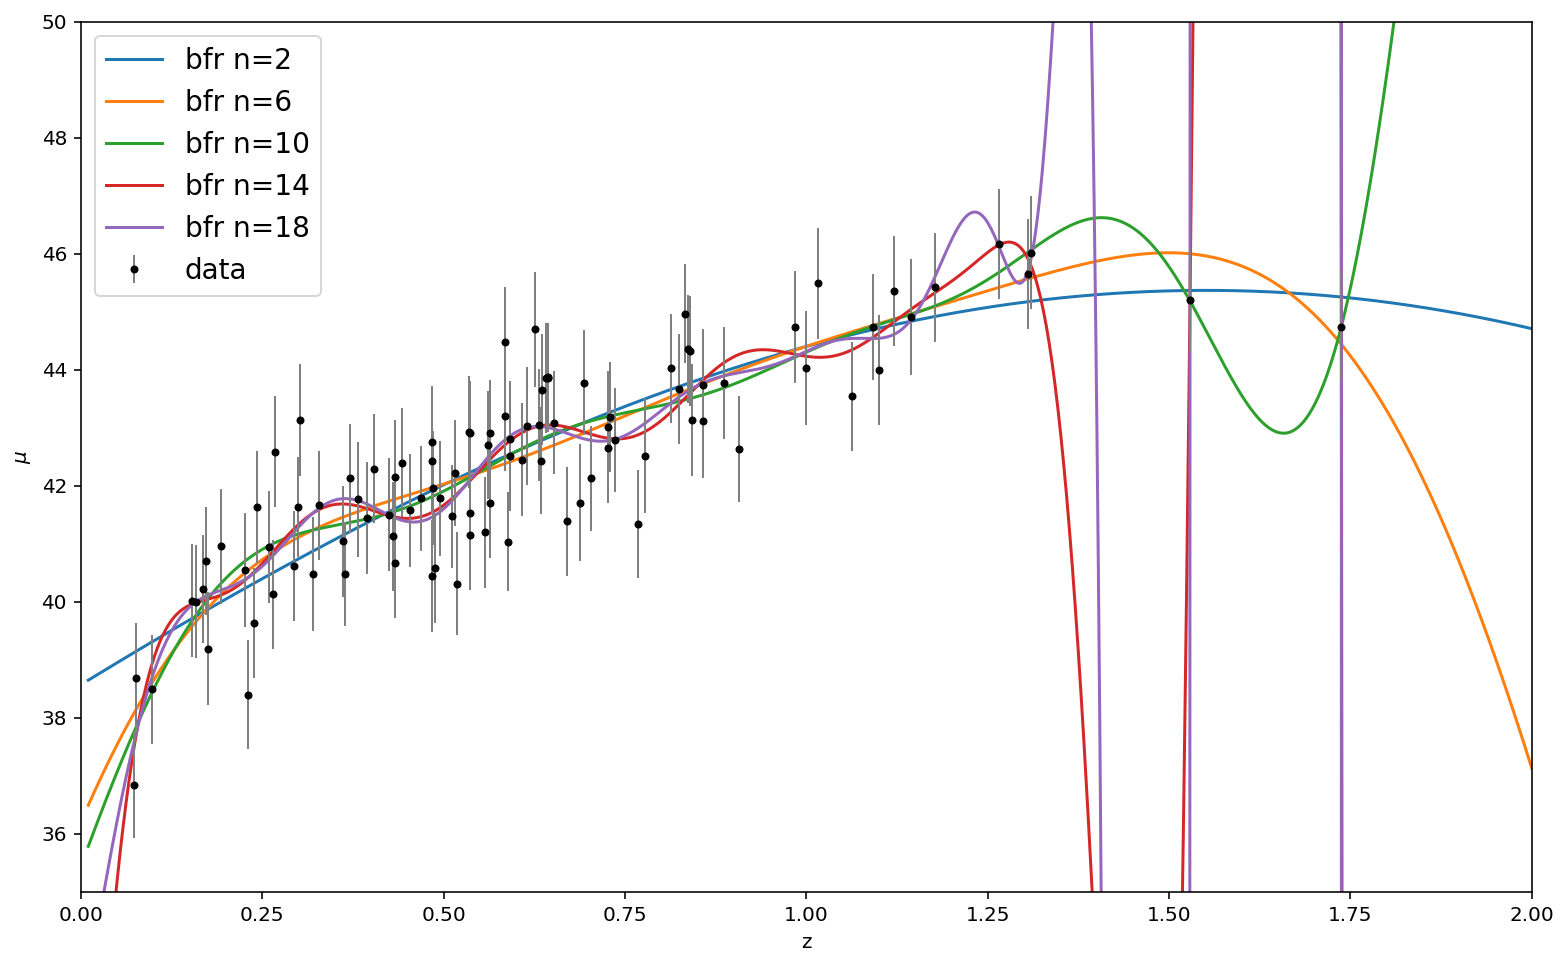

In [16]:
plt.figure(figsize=(13, 8))

for i in np.arange(1,20)[1::4]:  # best plotting option taken from solutions
    
    plt.plot(z, mu_pred_bfr[f'{i}'], label='bfr n='+str(i))
    
plt.errorbar(dataset_corr_[:, 0], dataset_corr_[:, 1], dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left', fontsize=14)
plt.xlim(0,2)
plt.ylim(35,50);

My guess from this fit is that a 2/6th degree polynomial could be a good choice to describe our data; the higher degrees are overfitting our data, as seen from the very strong oscillations in the model. 

### Kernel regression 

In [17]:
model_ker = {}
mu_pred_ker = {}

hs = np.linspace(0.01, 0.3, 7)  # bandwidth
indexes_names = np.arange(0, 7) 
    
for i, index in zip(hs, indexes_names):
    
    model_ker = NadarayaWatson(kernel='gaussian', h=i)
    model_ker.fit(dataset_corr_[:, 0][:, np.newaxis], dataset_corr_[:, 1])

    mu_pred_ker[f'{index}'] = model_ker.predict(z[:, None])

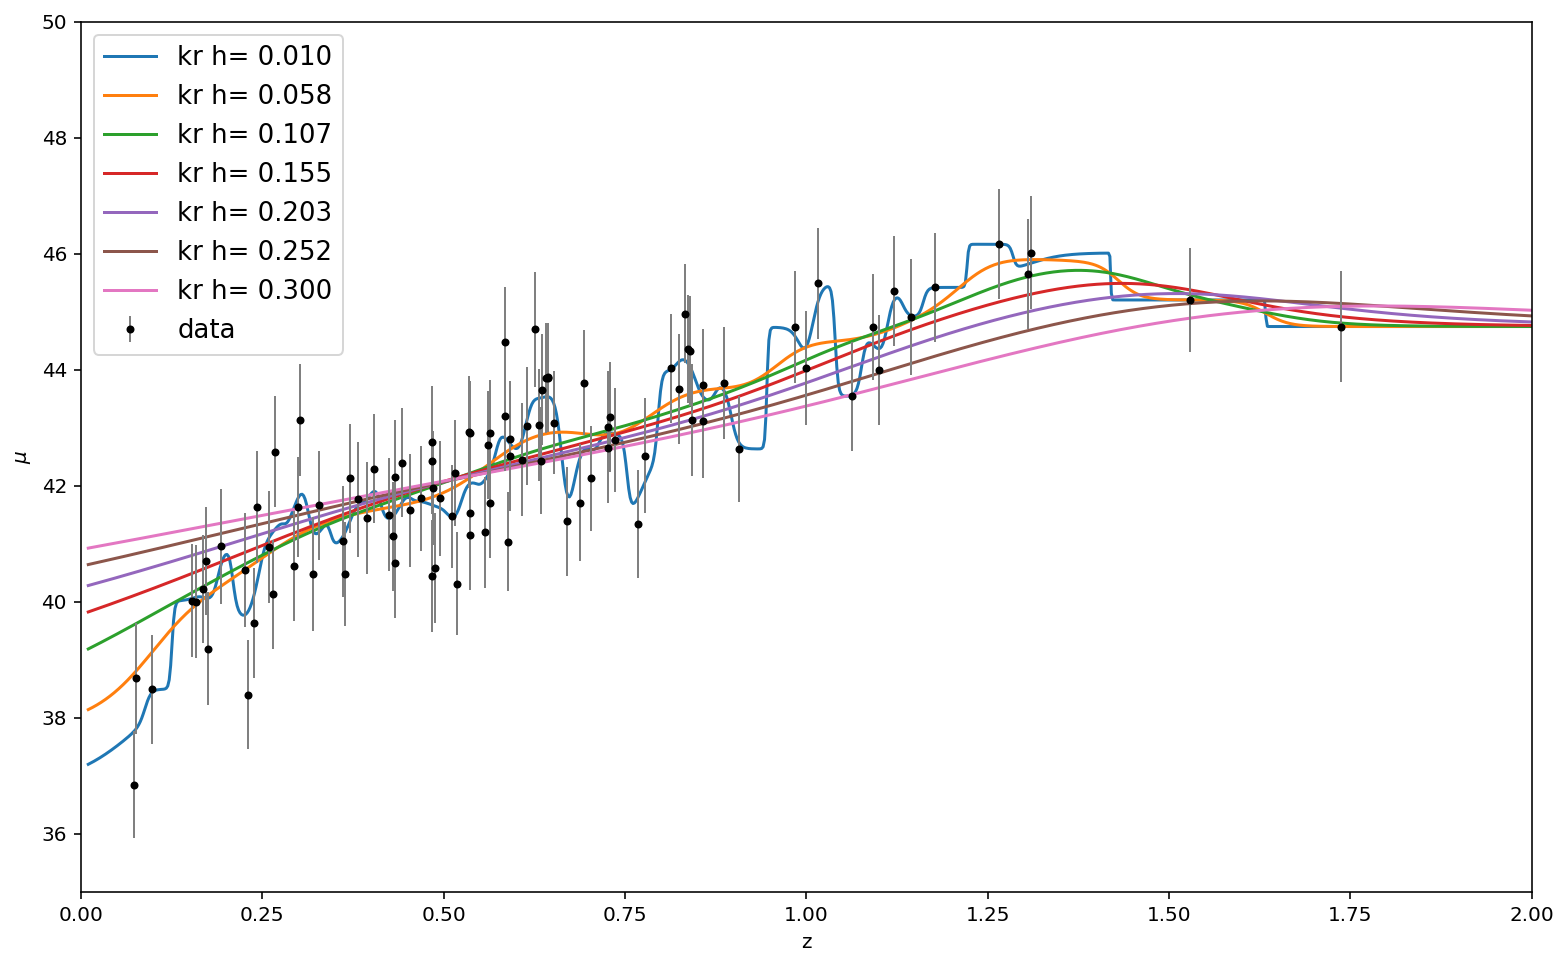

In [18]:
plt.figure(figsize=(13, 8))

for i in range(0, 7):  # best plotting option taken from solutions
    
    plt.plot(z, mu_pred_ker[f'{i}'], label='kr h= %.3f' % hs[i]) 
    
plt.errorbar(dataset_corr_[:, 0], dataset_corr_[:, 1], dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='upper left', fontsize=13)
plt.xlim(0,2)
plt.ylim(35,50);

I found this model intriguing because it didn't overfit the way the others did (very high variance). Overfit in this case means very little "maneuvre" space for newly takend data to be model-distributed. Too little the bandwidth, too little the possibility to use the model for future applications. In this case I'd choose some band between 0.1 and 0.2, to avoid the opposite behaviour, where we lose some important behaviour of data, especially at low z.  

---

# Cross Validation

$\textbf{Disclaimer}$: I decided to use the implementation of $\textit{K-Fold}$ that I found on the documentation, without implementing it myself due to indexes issues ([link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)). I manually changed the number of $\textit{K-Folds}$ $k$ until I found a convergent result. I think that the outliers strongly affect the error of our model especially when taken into the testing set, so I took a better proportion of training sets (90/100). 

In [19]:
# prepare nice data array: 

dataset_complete = np.array((z_sample, mu_sample, dmu)).T

In [20]:
dataset_complete.shape

(100, 3)

In [21]:
#cross validation functions

def error(X, y, regressor):
    
    #print(np.sqrt( np.sum(( y - regressor.predict(X) )**2) / len(X) ))
    
    return np.sqrt( np.sum(( y - regressor.predict(X) )**2) / len(X) )

    
def cv_vs_t_err(X, y, dy, regressor_type, k):
    
    kf = KFold(n_splits=k, shuffle=True, random_state=10)  # fixed the shuffling
    
    t_err = []
    cv_err = []
    
    for t_index, cv_index in kf.split(X):
        
        regressor_type.fit(X[t_index], y[t_index], dy[t_index])
        
        t_err.append(error(X[t_index], y[t_index], regressor_type))
        cv_err.append(error(X[cv_index], y[cv_index], regressor_type))
    
    return np.median(t_err), np.median(cv_err)  # chose median because mean strongly depends on outliers

Since the linear regression does not require any additional parameter, I am starting to cross validate from the Polynomial Regression. 

### Polynomial Regression

In [25]:
cv_err_pr = []
t_err_pr = []

for param in range(1, 7): 
    
    regressor_type = PolynomialRegression(param) 
    t_err_i, cv_err_i = cv_vs_t_err(dataset_complete[:, 0][:, None], dataset_complete[:, 1], dataset_complete[:, 2], regressor_type, 11)
    cv_err_pr.append(cv_err_i)
    t_err_pr.append(t_err_i)

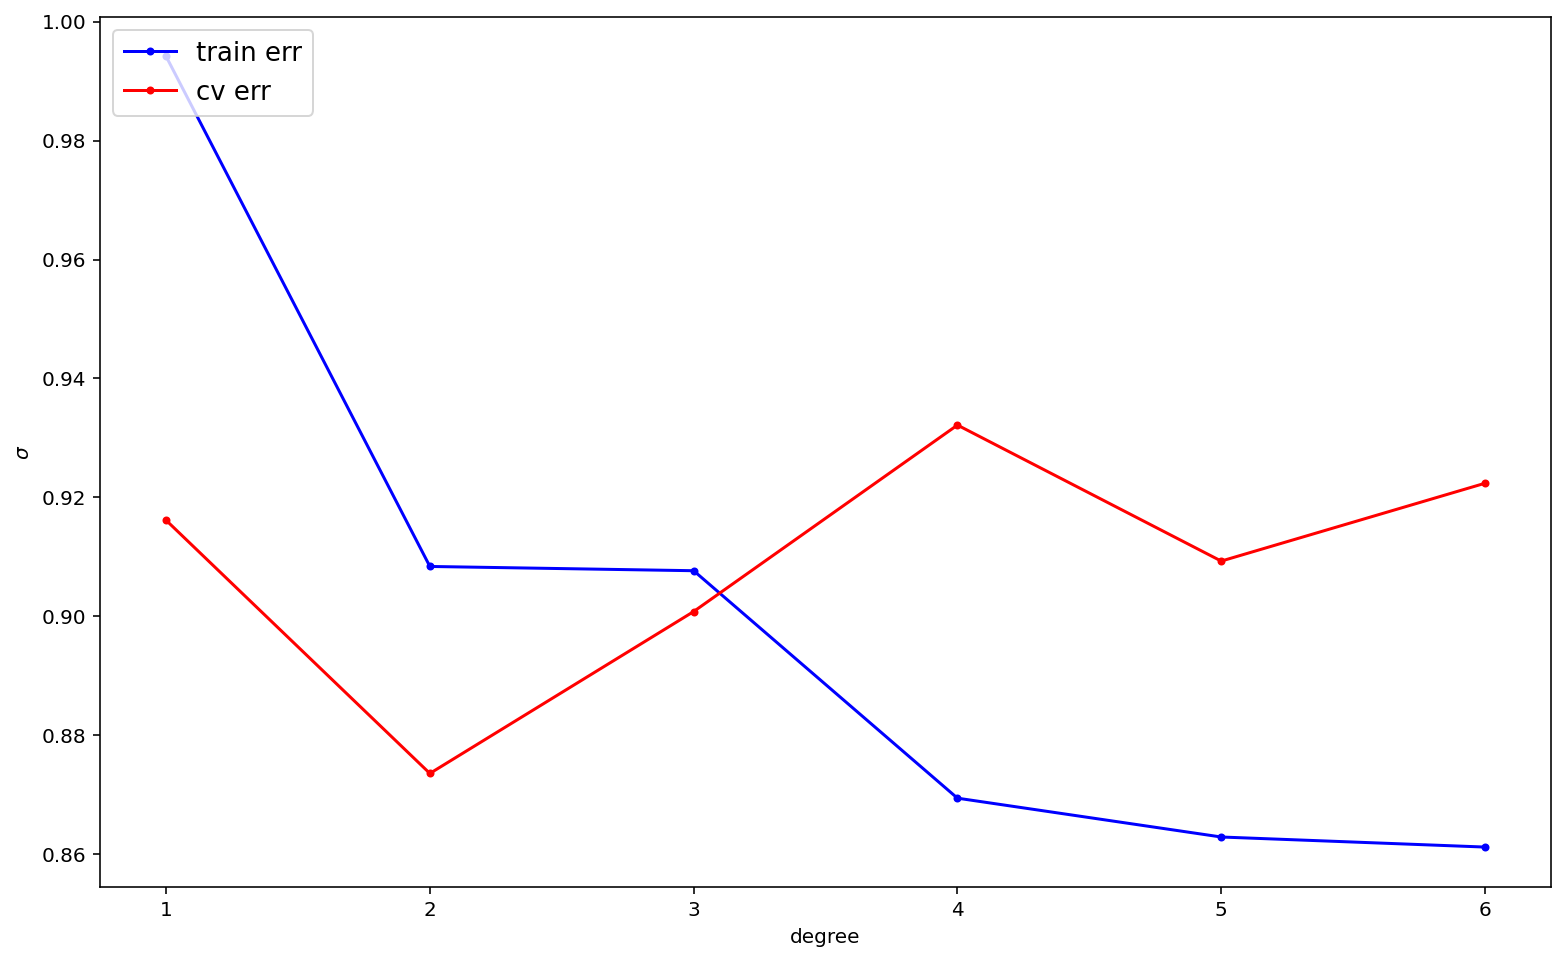

In [26]:
plt.figure(figsize=(13, 8))
plt.plot(np.arange(1, len(t_err_pr) + 1), t_err_pr, c='blue', label='train err', marker='.')
plt.plot(np.arange(1, len(cv_err_pr) + 1), cv_err_pr, c='red', label='cv err', marker='.')

plt.xlabel("degree")
plt.ylabel("$\sigma$")
plt.legend(loc='upper left', fontsize=13);

In [27]:
print("best component:", np.argmin(cv_err_pr) + 1, ", with error value:", np.min(cv_err_pr))

best component: 2 , with error value: 0.8736006812023651


### Basis function regression

In [28]:
cv_err_bfr = []
t_err_bfr = []
    
for i in np.arange(1, 20)[1::4]: 

    # mean positions of the i Gaussians in the model
    X_gridtest = np.linspace(0, 2, i)[:, None]

    # widths of these Gaussians
    sigma_test = float(X_gridtest[1]-X_gridtest[0])
    
    regressor_type = BasisFunctionRegression(basis_func='gaussian', mu=X_gridtest, sigma=sigma_test)
 
    t_err_i, cv_err_i = cv_vs_t_err(dataset_complete[:, 0][:, None], dataset_complete[:, 1], dataset_complete[:, 2], regressor_type, 11)
    cv_err_bfr.append(cv_err_i)
    t_err_bfr.append(t_err_i)

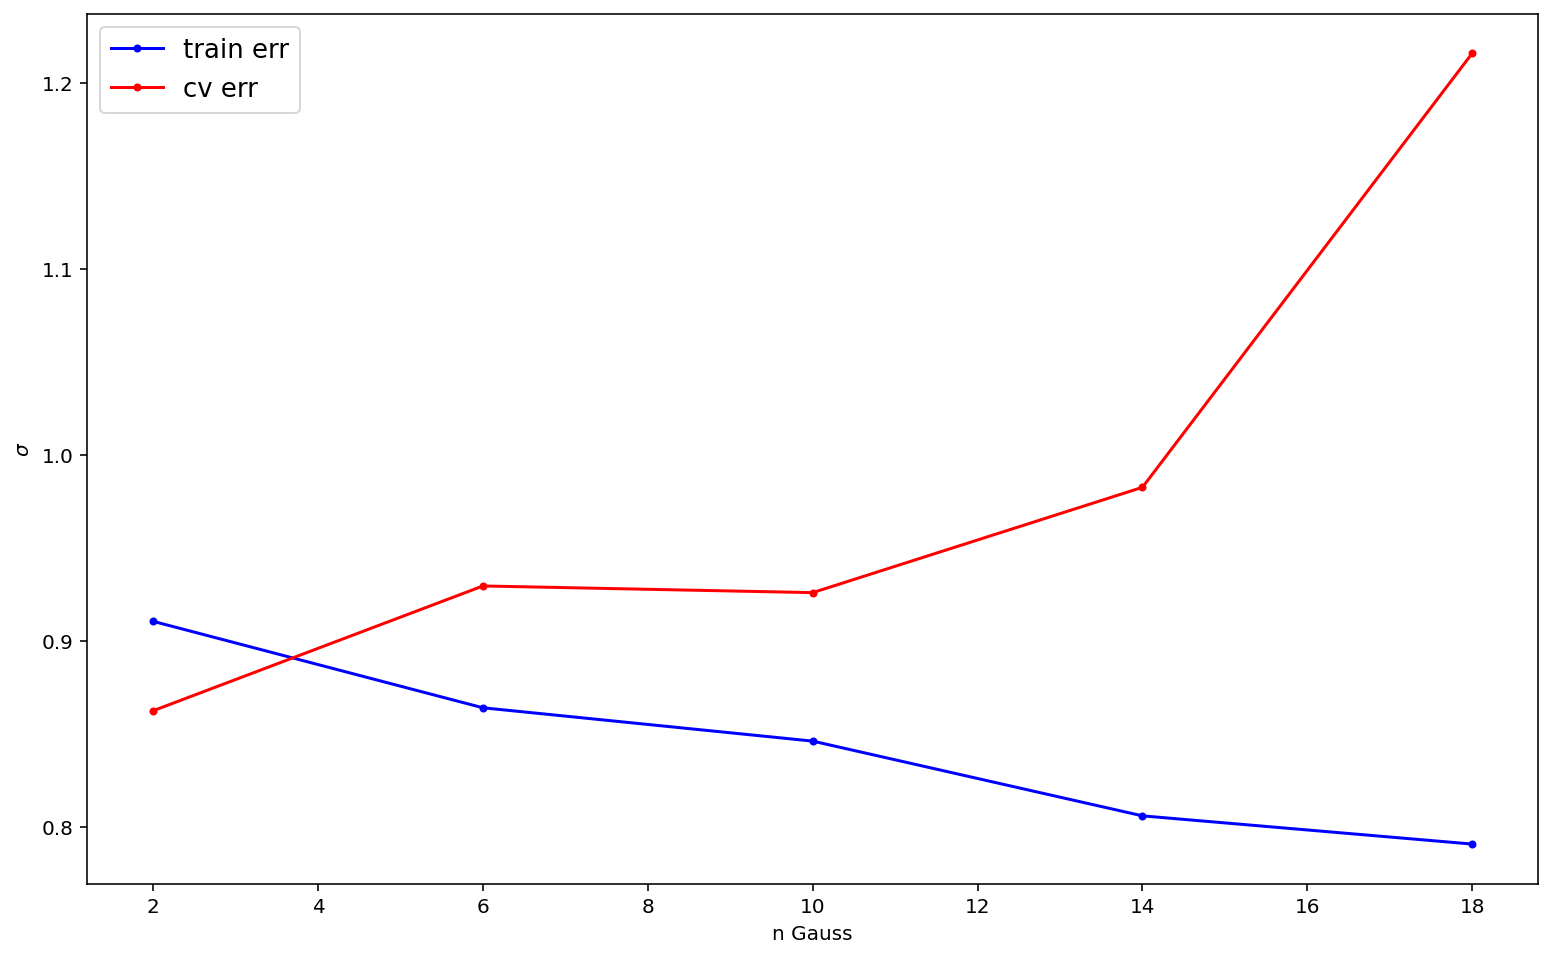

In [29]:
plt.figure(figsize=(13, 8))
plt.plot(np.arange(1,20)[1::4], t_err_bfr, c='blue', label='train err', marker='.')
plt.plot(np.arange(1,20)[1::4], cv_err_bfr, c='red', label='cv err', marker='.')

plt.xlabel("n Gauss")
plt.ylabel("$\sigma$")
plt.legend(loc='upper left', fontsize=13);

In [30]:
print("best component n_gauss:",np.arange(1,20)[1::4][np.argmin(cv_err_bfr)], ", with error value:", np.min(cv_err_bfr))

best component n_gauss: 2 , with error value: 0.8626607438766563


### Kernel regression

In [31]:
cv_err_na = []
t_err_na = []

hs = np.linspace(0.01, 0.3, 7)  # bandwidth
indexes_names = np.arange(0, 7) 
    
for i, index in zip(hs, indexes_names):
    
    regressor_type = NadarayaWatson(kernel='gaussian', h=i)
 
    t_err_i, cv_err_i = cv_vs_t_err(dataset_complete[:, 0][:, None], dataset_complete[:, 1], dataset_complete[:, 2], regressor_type, 8)
    cv_err_na.append(cv_err_i)
    t_err_na.append(t_err_i)

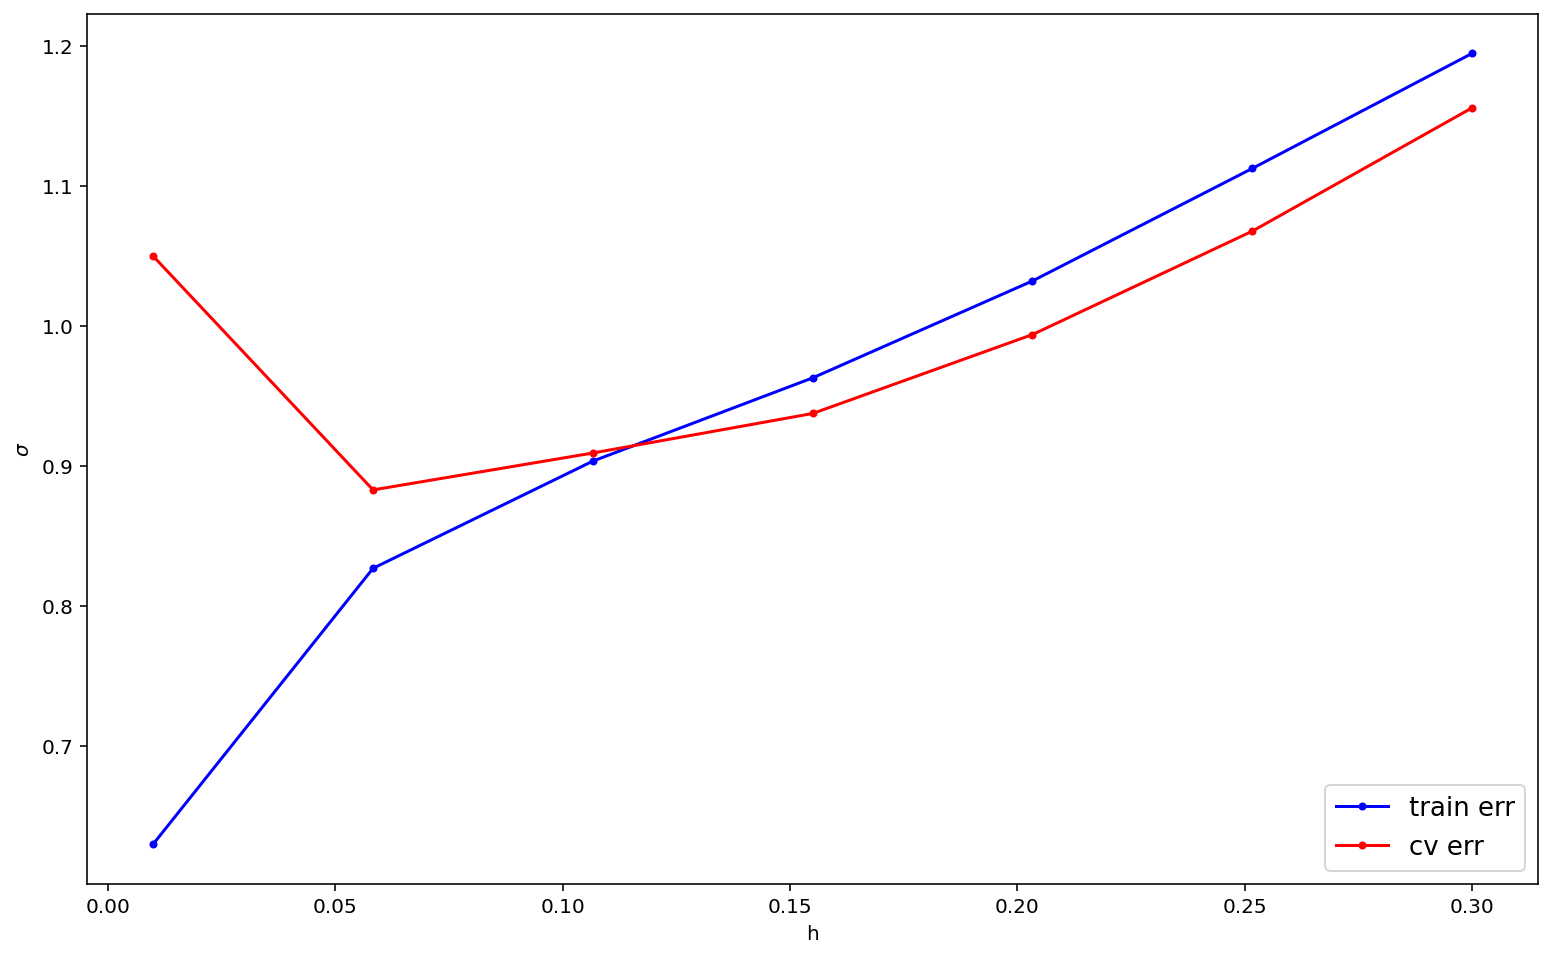

In [32]:
plt.figure(figsize=(13, 8))
plt.plot(np.linspace(0.01, 0.3, 7), t_err_na, c='blue', label='train err', marker='.')
plt.plot(np.linspace(0.01, 0.3, 7), cv_err_na, c='red', label='cv err', marker='.')

plt.xlabel("h")
plt.ylabel("$\sigma$")
plt.legend(loc='lower right', fontsize=13);

In [33]:
print("best component h:",np.linspace(0.01, 0.3, 7)[np.argmin(cv_err_na)], ", with error value:", np.min(cv_err_na))

best component h: 0.058333333333333334 , with error value: 0.8827535960453547


---

# Learning Curves

I now explore what happens when I change the number of datapoints and plot the resulting learning curves. I choose to set more points and then I move on to evaluate the CV and training error:

In [35]:
z_sample_NEW, mu_sample_NEW, dmu_NEW = generate_mu_z(1000, random_state=1234)

In [36]:
dataset_NEW = np.array((z_sample_NEW, mu_sample_NEW, dmu_NEW)).T

In [82]:
# keep only one CV for computational issues

X_train, X_test, ydy_train, ydy_test = train_test_split(dataset_NEW[:, 0], np.array((dataset_NEW[:, 1], dataset_NEW[:, 2])).T, test_size=0.33, random_state=42)
Y_train, dy_train = ydy_train.T
Y_test,dy_test = ydy_test.T

In [98]:
Y_train[:10].shape

(10,)

In [101]:
X_train[:10].shape

(10,)

### Kernel regression

In [113]:
N_cv_err_na = []
N_t_err_na = []
    
for N in range(10, 1000, 10):
                                                                                 
    ndarr = NadarayaWatson(kernel='gaussian', h=np.linspace(0.01, 0.3, 7)[np.argmin(cv_err_na)])
    ndarr.fit(X_train[:N][:, None], Y_train[:N], dy_train[:N])      
                                                                                                                                                             
    
    N_t_err_na.append(error(X_train[:N][:, None], Y_train[:N], ndarr))
                                                                                 
    N_cv_err_na.append(error(X_test[:, None], Y_test, ndarr))

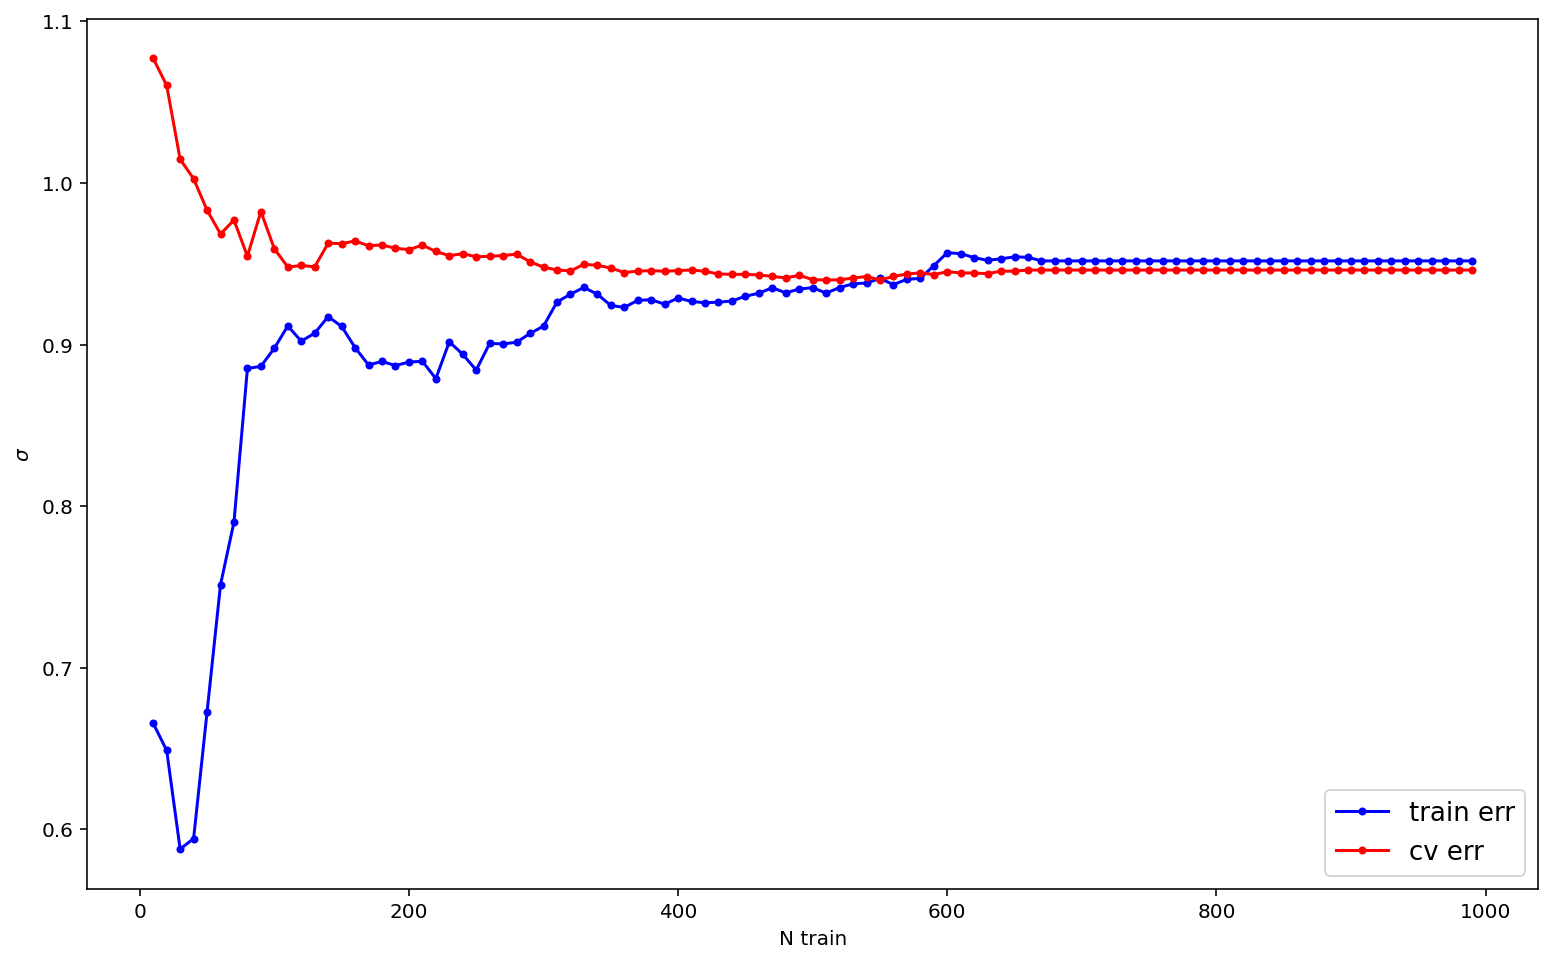

In [114]:
plt.figure(figsize=(13, 8))
plt.plot(range(10, 1000, 10), N_t_err_na, c='blue', label='train err', marker='.')
plt.plot(range(10, 1000, 10), N_cv_err_na, c='red', label='cv err', marker='.')

#ax.invert_xaxis()

plt.xlabel("N train")
plt.ylabel("$\sigma$")
plt.legend(loc='lower right', fontsize=13);

### Basis function regression

In [116]:
N_cv_err_bfr = []
N_t_err_bfr = []

for N in range(10, 1000, 10):
    
    # mean positions of the i Gaussians in the model
    X_gridtest = np.linspace(0, 2, np.arange(1,20)[1::4][np.argmin(cv_err_bfr)])[:, None]
    # widths of these Gaussians
    sigma_test = float(X_gridtest[1]-X_gridtest[0])
                                                                                 
    bfr = BasisFunctionRegression(basis_func='gaussian', mu=X_gridtest, sigma=sigma_test) 
    bfr.fit(X_train[:N][:, None], Y_train[:N], dy_train[:N])      
                                                                                                                                                             
    
    N_t_err_bfr.append(error(X_train[:N][:, None], Y_train[:N], bfr))
                                                                                 
    N_cv_err_bfr.append(error(X_test[:, None], Y_test, bfr))

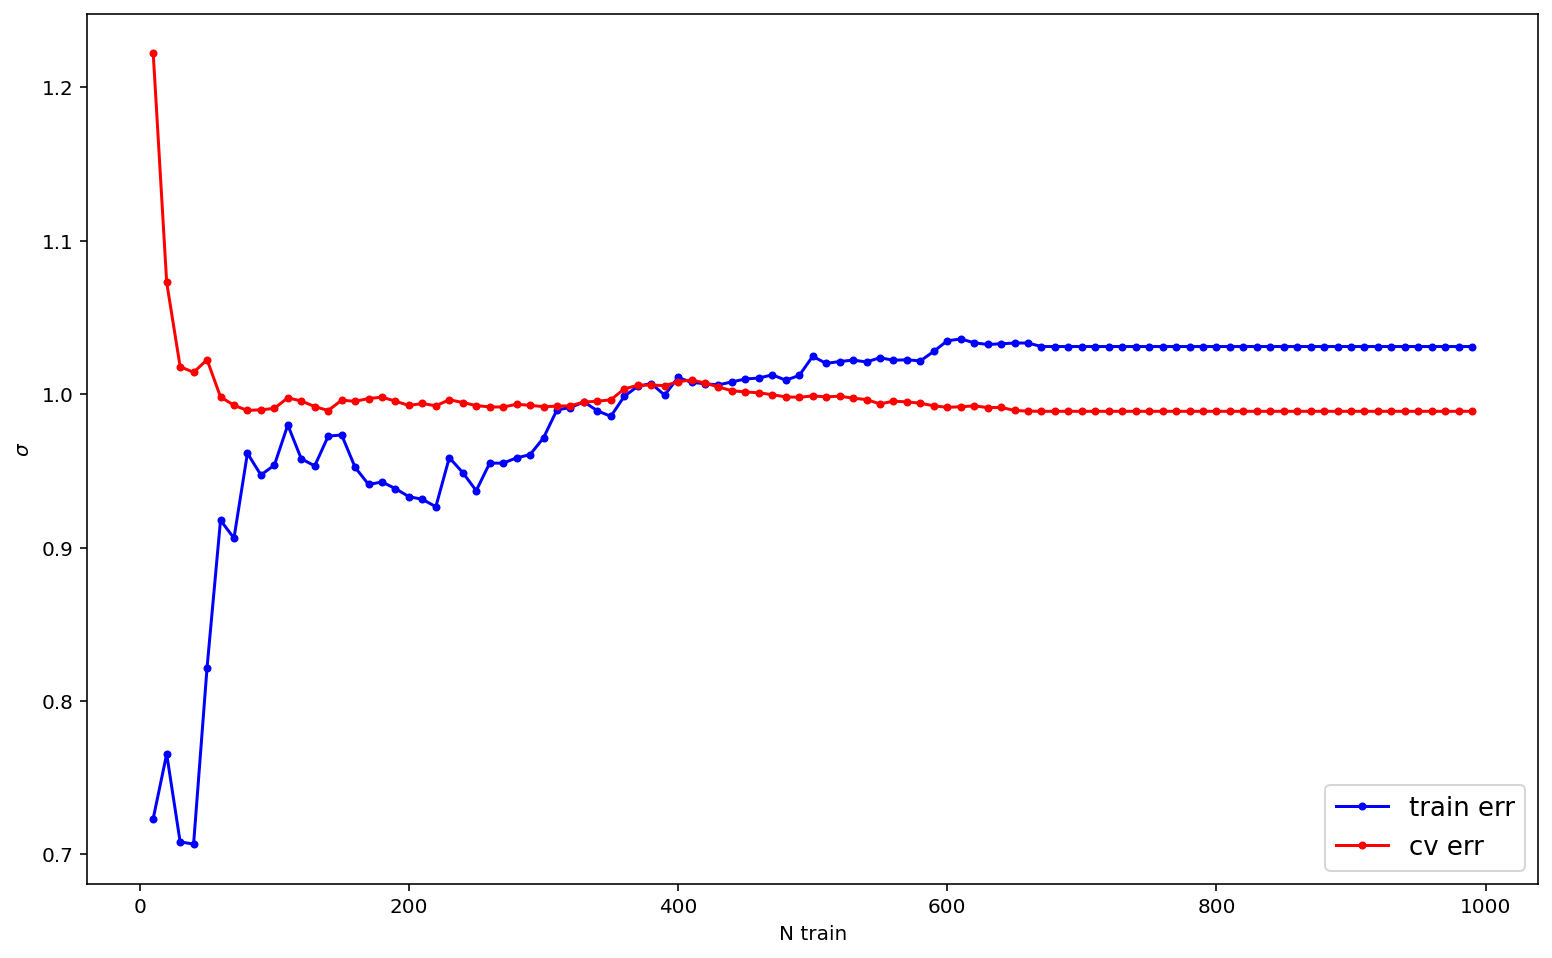

In [117]:
plt.figure(figsize=(13, 8))
plt.plot(range(10, 1000, 10), N_t_err_bfr, c='blue', label='train err', marker='.')
plt.plot(range(10, 1000, 10), N_cv_err_bfr, c='red', label='cv err', marker='.')

plt.xlabel("N train")
plt.ylabel("$\sigma$")
plt.legend(loc='lower right', fontsize=13);

In [110]:
N_cv_err_pr = []
N_t_err_pr = []

    
for N in range(10, 1000, 10):
                                                                                 
    pr = PolynomialRegression(np.argmin(cv_err_pr) + 1) 
    pr.fit(X_train[:N][:, None], Y_train[:N], dy_train[:N])      
                                                                                                                                                             
    
    N_t_err_pr.append(error(X_train[:N][:, None], Y_train[:N], pr))
                                                                                 
    N_cv_err_pr.append(error(X_test[:, None], Y_test, pr))

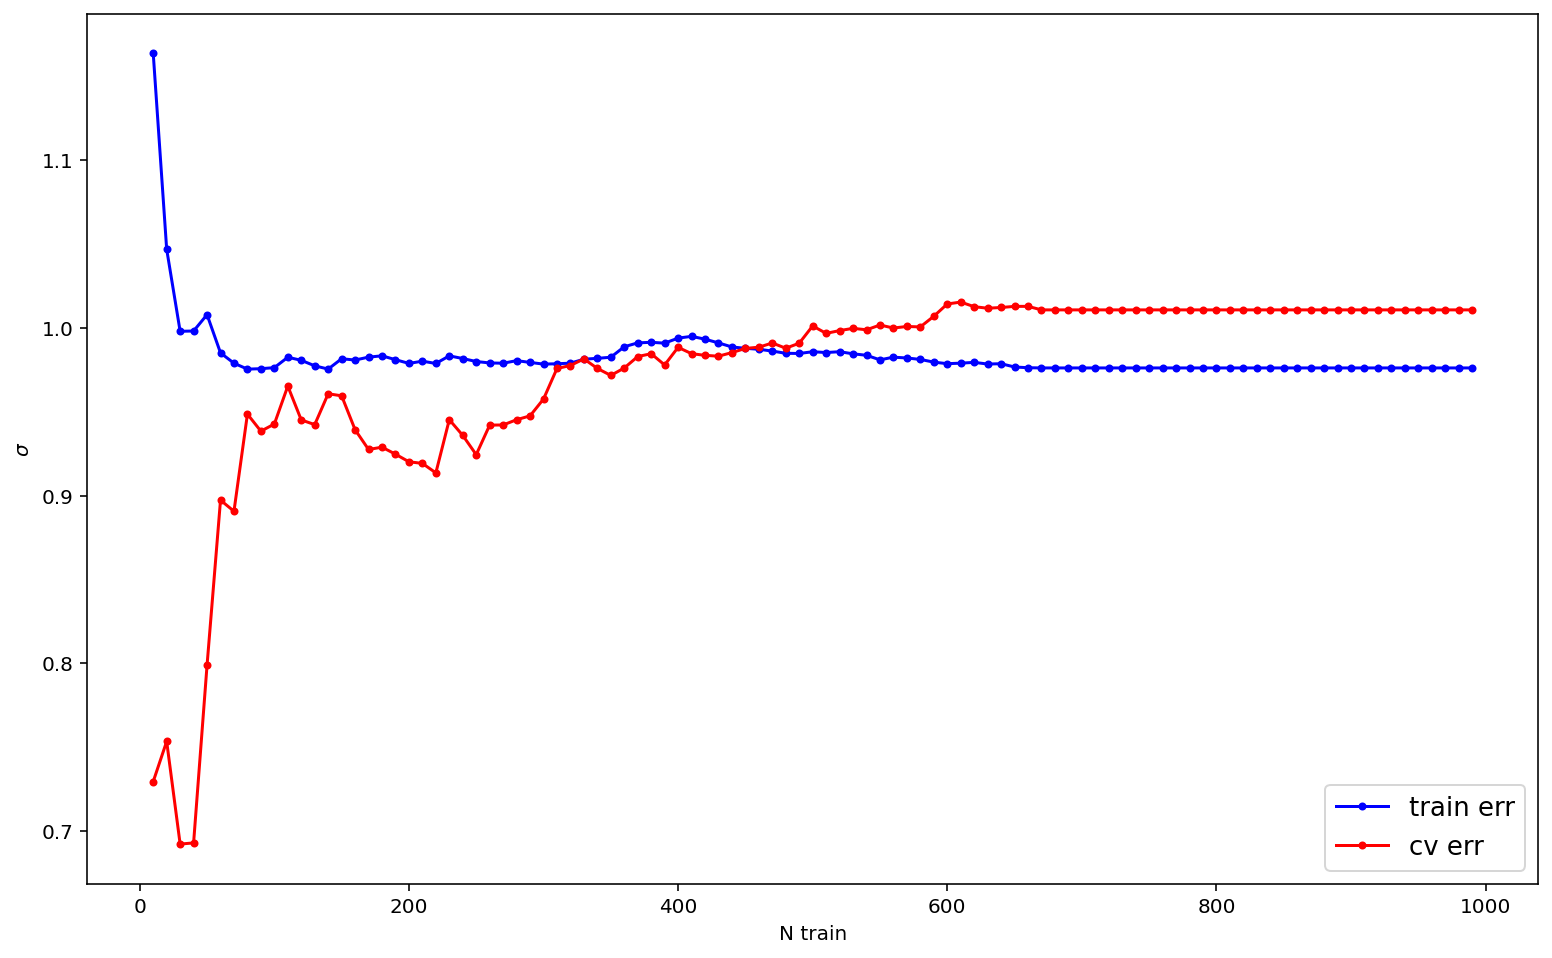

In [112]:
plt.figure(figsize=(13, 8))
plt.plot(range(10, 1000, 10), N_cv_err_pr, c='blue', label='train err', marker='.')
plt.plot(range(10, 1000, 10), N_t_err_pr, c='red', label='cv err', marker='.')

plt.xlabel("N train")
plt.ylabel("$\sigma$")
plt.legend(loc='lower right', fontsize=13);

---